# Определение перспективного тарифа для телеком компании

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

***Тариф «Смарт»***
+ Ежемесячная плата: 550 рублей
+ Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
+ Стоимость услуг сверх тарифного пакета:
+ минута разговора: 3 рубля
+ сообщение: 3 рубля
+ 1 Гб интернет-трафика: 200 рублей

***Тариф «Ультра»***
+ Ежемесячная плата: 1950 рублей
+ Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
+ Стоимость услуг сверх тарифного пакета:
+ минута разговора: 1 рубль
+ сообщение: 1 рубль
+ 1 Гб интернет-трафика: 150 рублей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

## Шаг 1

### Рассмотрим каждый датасет по отдельности.

***Таблица users (информация о пользователях):***
+ user_id — уникальный идентификатор пользователя
+ first_name — имя пользователя
+ last_name — фамилия пользователя
+ age — возраст пользователя (годы)
+ reg_date — дата подключения тарифа (день, месяц, год)
+ churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
+ city — город проживания пользователя
+ tariff — название тарифного плана

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [6]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [7]:
users.duplicated().sum()

0

Мы имеем 500 пользователей, 462 из которых ещё пользуются «Мегалайном»(351 пользователь тарифа "Смарт" и 149 пользователей тарифом "Ультра". Дубликатов и пропусков, которые нужно заменить, нет. В столбцах churn_date и reg_date нужно будет заменить тип данных на DateTime.

***Таблица calls (информация о звонках):***
+ id — уникальный номер звонка
+ call_date — дата звонка
+ duration — длительность звонка в минутах
+ user_id — идентификатор пользователя, сделавшего звонок

In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


 «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [10]:
len(calls[calls.duration < 1])

47927

In [11]:
calls.duplicated().sum()

0

In [12]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

В столбце call_date поменяем тип данных на DateTime. Так как оператор «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута, а у нас 47927 звонков меньше минуты, возможно ошибка при выгрузке. Округлим время с помощью метода .ceil и заменим 0 на 1.

***Таблица messages (информация о сообщениях):***
+ id — уникальный номер сообщения
+ message_date — дата сообщения
+ user_id — идентификатор пользователя, отправившего сообщение

In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [14]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [15]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [16]:
messages.duplicated().sum()

0

Столбец message_date переведём в тип данных DateTime.

***Таблица internet (информация об интернет-сессиях):***
+ id — уникальный номер сессии
+ mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
+ session_date — дата интернет-сессии
+ user_id — идентификатор пользователя

In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [18]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [19]:
internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [20]:
internet.duplicated().sum()

0

Так как оператор округляет в большую сторону не только минуты, но и мегобайты, найдём значения меньше единицы.

In [21]:
len(internet[internet.mb_used < 1])

19699

Столбец session_date приведём к типу DateTime. Как и в случае со звонками, мы имеем 19699 значений меньше единицы. Проделаем туже процедуру с помощью метода .ceil и заменой нулей на 1.

***Таблица tariffs (информация о тарифах):***
+ tariff_name — название тарифа
+ rub_monthly_fee — ежемесячная абонентская плата в рублях
+ minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
+ messages_included — количество сообщений в месяц, включённых в абонентскую плату
+ mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
+ rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
+ rub_per_message — стоимость отправки сообщения сверх тарифного пакета
+ rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [22]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [23]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


С типами данных всё хорошо. Есть ошибка в названии столбца mg_per_month_included, нужно переименовать.

## Шаг 2. Подготовим данные.

Заменим в запланированных столбцах тип данных.

In [24]:
dtformat = '%Y-%m-%d'
def to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=dtformat)

to_datetime(users, ['churn_date', 'reg_date'])
to_datetime(calls, ['call_date'])
to_datetime(messages, ['message_date'])
to_datetime(internet, ['session_date'])

Округлим минуты и мегабайты в датасетах calls и internet.

In [25]:
calls['duration'] = calls['duration'].apply(np.ceil)
nonzero_session = calls['duration'] > 0
calls['duration'].where(nonzero_session, 1, inplace=True)

In [26]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
nonzero_session = internet['mb_used'] > 0
internet['mb_used'].where(nonzero_session, 1, inplace=True)

Переименуем ошибки в датасете tariffs.

In [27]:
tariffs = tariffs.rename(columns={'mg_per_month_included':'mb_per_month_included', 'tariff_name':'tariff'})

In [28]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Посчитайте для каждого пользователя:

***Количество сделанных звонков и израсходованных минут разговора по месяцам***

In [29]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [30]:
calls_by_month = calls.pivot_table(
    index=['month', 'user_id'],
    values='duration',
    aggfunc=['count', 'sum']
)

In [31]:
calls_by_month.head()

count      sum
              duration duration
month user_id                  
1     1005          15     99.0
      1032          61    397.0
      1045           1      9.0
      1055          64    568.0
      1071          24    200.0

***Количество отправленных сообщений по месяцам***

In [32]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [33]:
messages_by_month = messages.pivot_table(
    index=['month', 'user_id'],
    values='id',
    aggfunc='count'
)

In [34]:
messages_by_month.head()

id
month user_id    
1     1005      7
      1032     38
      1045      5
      1055     30
      1071     16

***Объем израсходованного интернет-трафика по месяцам***

In [35]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [36]:
internet_by_month = internet.pivot_table(
    index=['month', 'user_id'],
    values='mb_used',
    aggfunc='sum'
)

In [37]:
internet_by_month.head()

mb_used
month user_id         
1     1005      2730.0
      1032     24158.0
      1045      2348.0
      1055     17115.0
      1071     15625.0

Для удобства объеденим эти таблицы в один датафрейм по столбцам month и user_id

In [38]:
user_by_month = pd.DataFrame()

In [39]:
tmp_df = pd.DataFrame(calls_by_month.to_records())

In [40]:
user_by_month['user_id'] = tmp_df['user_id']
user_by_month['month']   = tmp_df['month']
user_by_month['calls']   = tmp_df.iloc[:, 2]
user_by_month['minutes'] = tmp_df.iloc[:, 3]

In [41]:
tmp_df = pd.DataFrame(messages_by_month.to_records()).rename(columns={'id': 'messages'})

In [42]:
user_by_month = user_by_month.merge(tmp_df, on=['user_id', 'month'], how='outer')

In [43]:
tmp_df = pd.DataFrame(internet_by_month.to_records())

In [44]:
user_by_month = user_by_month.merge(tmp_df, on=['user_id', 'month'], how='outer')

In [45]:
user_by_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3174 non-null float64
minutes     3174 non-null float64
messages    2717 non-null float64
mb_used     3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


In [46]:
user_by_month.head()

,user_id,month,calls,minutes,messages,mb_used
0,1005,1,15.0,99.0,7.0,2730.0
1,1032,1,61.0,397.0,38.0,24158.0
2,1045,1,1.0,9.0,5.0,2348.0
3,1055,1,64.0,568.0,30.0,17115.0
4,1071,1,24.0,200.0,16.0,15625.0


При соединение появились пропуски и из-за них поменялся тип данных на float64. Вероятнее всего пользователи не пользовались некоторыми услугами. Заменим пропуски на нули и поменяем тип данных на int64.

In [47]:
gaps = ['calls', 'minutes', 'messages']

for g in gaps:
    user_by_month[g] = user_by_month[g].fillna(0).astype('int64')

In [48]:
user_by_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3214 non-null int64
minutes     3214 non-null int64
messages    3214 non-null int64
mb_used     3203 non-null float64
dtypes: float64(1), int64(5)
memory usage: 175.8 KB


In [49]:
user_by_month.head()

,user_id,month,calls,minutes,messages,mb_used
0,1005,1,15,99,7,2730.0
1,1032,1,61,397,38,24158.0
2,1045,1,1,9,5,2348.0
3,1055,1,64,568,30,17115.0
4,1071,1,24,200,16,15625.0


### Помесячную выручку с каждого пользователя

Добавим в датафрейм информацию о пользователях и тарифах.

In [50]:
user_by_month = user_by_month.merge(users, on='user_id', how='left').merge(tariffs, on='tariff', how='left')

In [51]:
user_by_month['minutes_over']  = user_by_month['minutes'] - user_by_month['minutes_included']
user_by_month['messages_over'] = user_by_month['messages'] - user_by_month['messages_included']
user_by_month['mb_used_over']  = user_by_month['mb_used'] - user_by_month['mb_per_month_included']

In [52]:
user_by_month.head()# Положительные значения указывают на перерасход. Отрицательные на остаток в рамках тарифа.

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over,messages_over,mb_used_over
0,1005,1,15,99,7,2730.0,67,NaT,Набережные Челны,Афанасий,...,50,15360,500,550,200,3,3,-401,-43,-12630.0
1,1032,1,61,397,38,24158.0,31,NaT,Ульяновск,Инна,...,50,15360,500,550,200,3,3,-103,-12,8798.0
2,1045,1,1,9,5,2348.0,48,NaT,Улан-Удэ,Джемма,...,50,15360,500,550,200,3,3,-491,-45,-13012.0
3,1055,1,64,568,30,17115.0,39,NaT,Казань,Луиза,...,50,15360,500,550,200,3,3,68,-20,1755.0
4,1071,1,24,200,16,15625.0,20,2018-08-31,Омск,Гектор,...,50,15360,500,550,200,3,3,-300,-34,265.0


Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика,
    остаток умножим на значение из тарифного плана.
    

In [53]:
def calc_monthly_revenue(row):
    
    minutes_price = 0
    messages_price = 0
    mb_used_price = 0
    
    # стоимость дополнительных минут
    if row['minutes_over'] > 0:
        minutes_price = row['minutes_over'] * row['rub_per_minute']

    # стоимость дополнительных сообщений
    if row['messages_over'] > 0:
        messages_price = row['messages_over'] * row['rub_per_message']

    # стоимость дополнительного трафика
    if row['mb_used_over'] > 0:
        mb_used_price = (row['mb_used_over'] / 1024) * row['rub_per_gb']
    
    return minutes_price + messages_price + mb_used_price

In [54]:
user_by_month['rub_monthly_fee_over'] = user_by_month.apply(calc_monthly_revenue, axis=1)
user_by_month['rub_monthly_fee_total'] = user_by_month['rub_monthly_fee'] + user_by_month['rub_monthly_fee_over']

In [55]:
user_by_month = pd.DataFrame(
    user_by_month[['month', 'tariff', 'user_id', 'city',
           'calls', 'minutes', 'messages', 'mb_used',
           'minutes_over', 'messages_over', 'mb_used_over',
           'rub_monthly_fee_over', 'rub_monthly_fee_total']]
)# Датафрейм только с нужными нами данными

In [56]:
user_by_month.head()

,month,tariff,user_id,city,calls,minutes,messages,mb_used,minutes_over,messages_over,mb_used_over,rub_monthly_fee_over,rub_monthly_fee_total
0,1,smart,1005,Набережные Челны,15,99,7,2730.0,-401,-43,-12630.0,0.000000,550.000000
1,1,smart,1032,Ульяновск,61,397,38,24158.0,-103,-12,8798.0,1718.359375,2268.359375
2,1,smart,1045,Улан-Удэ,1,9,5,2348.0,-491,-45,-13012.0,0.000000,550.000000
3,1,smart,1055,Казань,64,568,30,17115.0,68,-20,1755.0,546.773438,1096.773438
4,1,smart,1071,Омск,24,200,16,15625.0,-300,-34,265.0,51.757812,601.757812


In [57]:
smart_user = user_by_month.query("tariff == 'smart'")

In [58]:
len(smart_user.groupby('user_id'))

350

In [59]:
ultra_user = user_by_month.query("tariff == 'ultra'")

In [60]:
len(ultra_user.groupby('user_id'))

148

В нашей таблице записи о 350 пользователей тарифом Смарт и 148 пользователей тарифом Ульта. Информации о  расходах 2 пользователей(по 1 от каждого тарифа) нету. 

## Шаг 3. Проанализируем  данные

Опишем поведение клиентов оператора, исходя из выборки.

In [61]:
# Сделаем сводную таблицу по тарифам в разрезе месяцев
tariff_monthly_costs = user_by_month.pivot_table(
    index=['tariff', 'month'],
    values=['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total']
)

In [62]:
smart_monthly_costs = tariff_monthly_costs.loc['smart']
smart_monthly_costs

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
month,,,,,
1,8528.588235,18.235294,209.647059,154.895910,704.895910
2,11617.344828,24.086207,306.310345,262.159752,812.159752
3,15131.207792,31.857143,400.532468,583.213271,1133.213271
4,13486.080357,30.741071,377.000000,384.781878,934.781878
5,15832.751773,33.773050,398.404255,611.004377,1161.004377
6,15822.445122,33.402439,406.701220,614.601038,1164.601038
7,15771.398010,33.751244,419.288557,635.629392,1185.629392
8,16711.324786,33.638298,433.191489,726.647008,1276.647008
9,16332.615385,33.638462,440.080769,667.753456,1217.753456


In [63]:
ultra_monthly_costs = tariff_monthly_costs.loc['ultra']
ultra_monthly_costs

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
month,,,,,
1,13154.666667,33.777778,440.888889,0.000000,1950.000000
2,12860.000000,21.958333,304.666667,23.095703,1973.095703
3,17553.513514,32.297297,503.081081,54.254645,2004.254645
4,16845.254545,31.563636,470.072727,45.474077,1995.474077
5,19676.878788,37.850746,524.865672,105.022738,2055.022738
6,19172.168675,41.726190,492.428571,82.109724,2032.109724
7,20744.533333,49.846154,560.296703,158.562092,2108.562092
8,19780.745283,48.439252,524.570093,121.230195,2071.230195
9,19392.675439,52.286957,553.643478,63.776749,2013.776749


***Минуты разговора, количество сообщений и объём интернет-трафика в среднем необходимые пользователям каждого тарифа в месяц***

In [64]:
tariff_usage = tariff_monthly_costs.pivot_table(
    index='tariff',
    values=['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total']
)


In [65]:
tariff_usage

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
tariff,,,,,
smart,15091.033082,31.413211,397.374228,595.673948,1145.673948
ultra,18445.022099,43.714983,509.356551,88.972927,2038.972927


Пользователи тарифа Ультра более активны. Пользователи тарифа Смарт тратят в среднем в 6,5 раз больше на дополнительные пакеты услуг, хоть это всё равно меньше стоимости тарифа Ульта. Для пользователей выгоднее тариф Смарт, для оператора тариф Ультра.

***Дисперсия и стандартное отклонение***

*Минуты разговора*

In [66]:
smart_user['minutes'].describe()

count    2229.000000
mean      429.450875
std       194.871174
min         0.000000
25%       291.000000
50%       435.000000
75%       560.000000
max      1471.000000
Name: minutes, dtype: float64

In [67]:
ultra_user['minutes'].describe()

count     985.000000
mean      540.779695
std       325.738740
min         0.000000
25%       292.000000
50%       532.000000
75%       773.000000
max      1727.000000
Name: minutes, dtype: float64

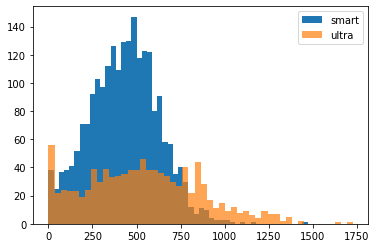

In [68]:
plt.hist(smart_user['minutes'], bins=50, label='smart')
plt.hist(ultra_user['minutes'], bins=50, label='ultra', alpha=0.7)
plt.legend(loc='upper right')
plt.show()

In [69]:
smart_minutes_var = np.var(smart_user['minutes'], ddof=1)
ultra_minutes_var = np.var(ultra_user['minutes'], ddof=1)

In [70]:
smart_minutes_var

37974.774627825

In [71]:
ultra_minutes_var

106105.72682307787

In [72]:
smart_minutes_std = np.std(smart_user['minutes'], ddof=1)
ultra_minutes_std = np.std(ultra_user['minutes'], ddof=1)

In [73]:
smart_minutes_std

194.87117444051339

In [74]:
ultra_minutes_std

325.7387401324532

+ Среднее тарифа Смарт 435 минут, дисперсия  37975, стандартное отклонение 195. 
+ Среднее тарифа Ультра 532 минут, дисперсия  106106, стандартное отклонение 325.

*Количество сообщений*

In [75]:
smart_user['messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

In [76]:
ultra_user['messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

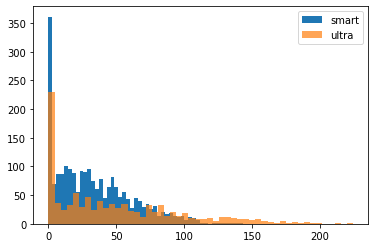

In [77]:
plt.hist(smart_user['messages'], bins=50, label='smart')
plt.hist(ultra_user['messages'], bins=50, label='ultra', alpha=0.7)
plt.legend(loc='upper right')
plt.show()

In [78]:
smart_messages_var = np.var(smart_user['messages'], ddof=1)
ultra_messages_var = np.var(ultra_user['messages'], ddof=1)

In [79]:

smart_messages_std = np.std(smart_user['messages'], ddof=1)
ultra_messages_std = np.std(ultra_user['messages'], ddof=1)

In [80]:
smart_messages_var

796.8129584480083

In [81]:
smart_messages_std

28.22787555676141

In [82]:
ultra_messages_var

2285.266142544674

In [83]:
ultra_messages_std

47.80445735017472

+ Среднее тарифа Смарт 28 сообщений, дисперсия 797, стандартное отклонение 28.
+ Среднее тарифа Ультра 38 сообщений, дисперсия 2285, стандартное отклонение 48.

*Интернет-трафик*

In [84]:
smart_user['mb_used'].describe()

count     2228.000000
mean     16244.472172
std       5871.037024
min          1.000000
25%      12673.250000
50%      16541.500000
75%      20078.750000
max      38627.000000
Name: mb_used, dtype: float64

In [85]:
ultra_user['mb_used'].describe()

count      975.000000
mean     19688.587692
std       9952.830482
min          1.000000
25%      12022.000000
50%      19416.000000
75%      26921.500000
max      49793.000000
Name: mb_used, dtype: float64

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


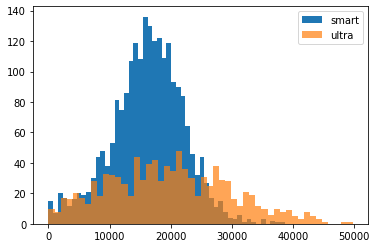

In [86]:
plt.hist(smart_user['mb_used'], bins=50, label='smart')
plt.hist(ultra_user['mb_used'], bins=50, label='ultra', alpha=0.7)
plt.legend(loc='upper right')
plt.show()

In [87]:
smart_mb_used_var = np.var(smart_user['mb_used'], ddof=1)
ultra_mb_used_var = np.var(ultra_user['mb_used'], ddof=1)

In [88]:
smart_mb_used_std = np.std(smart_user['mb_used'], ddof=1)
ultra_mb_used_std = np.std(ultra_user['mb_used'], ddof=1)

In [89]:
smart_mb_used_var

34469075.73833619

In [90]:
smart_mb_used_std

5871.037024098569

In [91]:
ultra_mb_used_var

99058834.60600853

In [92]:
ultra_mb_used_std

9952.83048212962

+ Среднее тарифа Смарт 16,541 Мб, дисперсия 3,4469,076, стандартное отклонение 5,871.
+ Среднее тарифа Ультра 19,416 Мб, дисперсия 99,058,834, стандартное отклонение 9,953.

***Перед тем, как делать расчеты и строить сводные таблицы, мы могли бы избавиться от выбросов в данных, но тогда был бы риск потерять часть датасета за какой-то временной промежуток из наших выборочных совокупностей.***

## Шаг 4. Проверим гипотезы
+ Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
+ Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Мы рассматриваем две генеральные сопокупности – пользователей разных тарифов мобильного оператора. Проверим две (двусторонние) гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

***Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается***

+ Средняя выручка пользователя тарифа "Смарт": 1145.67 руб
+ Средняя выручка пользователя тарифа "Ультра": 2038.97 руб

Нулевая гипотеза: *Средняя выручка пользователей тарифов Ультра и Смарт* ***не различается***

Альтернативная гипотеза: *Средняя выручка пользователей тарифов Ультра и Смарт* ***различаются***

Пороговое значение alpha (критический уровень статистической значимости) зададим равным 3%.

In [93]:
alpha = .03

results = st.ttest_ind(
    smart_user['rub_monthly_fee_total'], 
    ultra_user['rub_monthly_fee_total'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.009674149482176e-180
Отвергаем нулевую гипотезу


Средняя выручка по тарифам не одинакова, и практически нулевая вероятность говорит о том, что случайно получить такое отличие в значениях практически не получится. Следовательно, средняя выручка пользователей тарифов "Ультра" и "Смарт" действительно различается и наша гипотеза подтвердилась.

---
## Комментарий от наставника

Гипотезы сформулированы и проверены верно. Средние значения каждой из выборок можно сравнивать только совместно с их доверительными интервалами. Иначе дисперсия может быть довольно большой, и данное различие в средних будет малозначимо.

---

***Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов***

In [94]:
moscow = user_by_month['city'] == 'Москва'
user_by_month['city'].where(moscow, 'Другой регион', inplace=True)

city_monthly_costs = user_by_month.pivot_table(
    index=['city', 'month']
)

In [95]:
city_usage = city_monthly_costs.pivot_table(
    index='city',
    values=['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total']
)
city_usage

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
city,,,,,
Другой регион,15758.440143,35.268458,424.594742,451.974045,1398.514093
Москва,17603.175813,33.944639,455.792652,388.889460,1483.854730


+ Средняя выручка пользователей из Москвы: 1483.85 руб
+ Средняя выручка пользователей из других регионов: 1398.5 руб

Нулевая гипотеза: *Cредняя выручка пользователей из Москвы от выручки пользователей из других регионов* ***не отличается***

Альтернативная гипотеза: *Cредняя выручка пользователей из Москвы от выручки пользователей из других* регионов ***отличается***

Пороговое значение alpha (критический уровень статистической значимости) зададим равным 7%.

In [96]:
alpha = .07

moscow = user_by_month.query("city == 'Москва'")['rub_monthly_fee_total']
other_cities = user_by_month.query("city == 'Другой регион'")['rub_monthly_fee_total']

results = st.ttest_ind(moscow, other_cities)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5220687323801865
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из Москвы и регионов неодинакова, с вероятностью в почти 52% такое различие можно получить случайно. Как мы уже знаем, это слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками. Таким образом, средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, и наша гипотеза не подтвердилась.

## Шаг 5. Общий вывод

*«Мегалайн» — федеральный оператор сотовой связи. Отвечая на главный вопрос коммерческого департамента: "Какой тариф лучше?". Мы скажем, что тариф ***"Ультра"***, ведь средняя выручка пользователя по нему состовляет 2038.97 руб, это почти в два раза больше средней выручки пользователя тарифа "Смарт": 1145.67 руб. Так же этот результат мы подтвердили, проверив нашу гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.Вторая гипотеза не подтвердилась, средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.* 